<a href="https://colab.research.google.com/github/fmejias/CienciasDeLosDatosTEC/blob/master/TP2/TP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Matemáticas para Ciencias de los Datos
# Trabajo práctico 2

- Professor: M.Sc.Saul Calderon.

- Students: 
    - María Auxiliadora Mora, Instituto Tecnológico de Costa Rica  
    - Felipe Alberto Mejías Loría, Instituto Tecnológico de Costa Rica. 

- June 1th, 2019   

In [0]:
# Libraries required for the exercises
import torch as torch
import numpy as np
import random
import math

from torch.distributions import constraints
from torch.distributions.distribution import Distribution
from torch.distributions.utils import _standard_normal, lazy_property

import torch.distributions as distrib

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from numpy import linalg as linalg


# 1) Generar puntos plano (20 puntos)



Matrix X: 
 tensor([[  3.0000,   3.6000,   4.2000,   4.8000,   5.4000,   6.0000,   6.6000,
           7.2000,   7.8000,   8.4000,   9.0000,   9.6000,  10.2000,  10.8000,
          11.4000,  12.0000,  12.6000,  13.2000,  13.8000,  14.4000],
        [ 20.0000,  26.5000,  33.0000,  39.5000,  46.0000,  52.5000,  59.0000,
          65.5000,  72.0000,  78.5000,  85.0000,  91.5000,  98.0000, 104.5000,
         111.0000, 117.5000, 124.0000, 130.5000, 137.0000, 143.5000],
        [ 20.5855,  27.1466,  33.8254,  40.4775,  47.1162,  53.6823,  60.3361,
          66.9252,  73.6678,  80.1021,  86.7921,  93.4011, 100.0784, 106.5543,
         113.2223, 119.8583, 126.4299, 133.0853, 139.8828, 146.3874]])


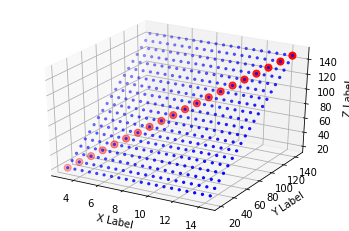

In [2]:
# Exercise 1
def generarPuntosPlano(n=20, mean=0, standardDeviation=0.05):
  """
  This function calculates a dataset and the plot them in 3D
  n: number of points
  mean: mean for the Gaussian distribution
  standardDeviation: standardDeviation for the Gaussian distribution
  return a plot in 3D of the dataset
  """
  
  def scatterPlotDataset3D(x, y ,z, epsilon):
    """
    Scatter plot the dataset
    param dataset: dataset to plot  
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Create 2D tensors with variation along the two axis
    X,Y = torch.meshgrid(x, y)

    # Compute hiperplane function to scattered all plane
    Z = 0.2 * X + Y + epsilon
    
    # Scattered all plane
    ax.scatter(X.numpy(), Y.numpy(), Z.numpy(), c='b', marker='.')
    
    # Scattered n points
    ax.scatter(x.numpy(), y.numpy(), z.numpy(), s=50, c='r', marker='o')

    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')

    plt.show()
    
  def epsilon():
    """
    Create Dataset with gaussian distribution
    param numSamples, number of samples
    """
    #create Gaussian distribution
    distribution = distrib.Normal(mean, standardDeviation)
    #create dataset from distribution
    return distribution.sample((n,))
  
  def plottingPlane():
    
    # Create 1D tensors x and y
    x = torch.arange(3, 15, 0.6)
    y = torch.arange(20, 150, 6.5)
    e = epsilon()
    
    # Hiperplane function
    z = 0.2 * x + y + e
    
    # Save points on a Matrix X
    matrixX = [x, y , z]
    matrixX = torch.stack(matrixX)
    print("Matrix X: \n", matrixX)
    
    # Scattered points in the plane
    scatterPlotDataset3D(x ,y, z, e)
    
    return matrixX
    
  # Plot the dataset  
  return plottingPlane()
  
  
# Test exercise 1
matrizX = generarPuntosPlano()


# 2) Calcular EigenVectores y Valores (30 puntos)

Matriz de covarianza de X: 
 tensor([[  12.6000,  136.5000,  139.0143],
        [ 136.5000, 1478.7500, 1505.9877],
        [ 139.0143, 1505.9877, 1533.7307]])
Eigenvalues: 
 tensor([[3.0251e+03, 0.0000e+00],
        [1.0244e-05, 0.0000e+00],
        [1.8641e-03, 0.0000e+00]])
Eigenvectors: 
 tensor([[ 0.0645, -0.9968,  0.0627],
        [ 0.6992,  0.0789,  0.7093],
        [ 0.7120,  0.0128, -0.7021]])
Base Matrix: 
 tensor([[ 0.0645,  0.0627],
        [ 0.6992,  0.7093],
        [ 0.7120, -0.7021]])


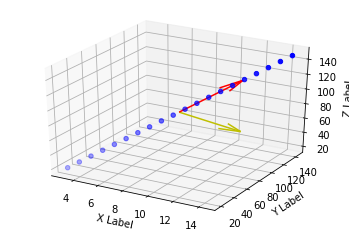

In [11]:
## Exercise 2
def calcularEigenvectoresYValores(X):
  """
  This function calculates eigen vectors and values
  X: matrix from exercise 1
  n: number of eigen vectors to extract
  return a plot in 3D of the dataset
  """
  
  def covariance(A) :
      """
      Calculate the covariance of a matrix 
      A: Matrix with the set of samples.
      Return: The covariance matrix of A
      """
      # the rows mean of A  
      AMean= A.mean(1)

      #1 / (Number of samples - 1)
      n = (1/(A.shape[1]-1))

      #Calculate the transpose of the rows mean. 
      w2Drow = AMean.reshape(-1, AMean.shape[0])
      AMeanT = w2Drow.transpose(0, 1)


      # Calculate the mean of A minus A.
      UA = AMeanT - A

      # Compute the UA transpose. 
      UAT= UA.transpose(0,1)

      # Covariance of A
      Cov = n * UA.mm(UAT)

      return Cov
    
  def plotEigenVectorsAndScatteredPoints(X, eigenVector1, eigenVector2):
      """
      Plot EigenVectors and Scattered Matrix Points
      A: Matrix with the set of samples.
      """
      fig = plt.figure()
      ax = fig.add_subplot(111, projection='3d')

      # Scattered matrix points
      ax.scatter(X[0, :].numpy(), X[1, :].numpy(), X[2, :].numpy(), c='b', marker='o')
      
      # Plot vector1
      meanSamplePerVariable = torch.mean(X, 1)
      x0 = meanSamplePerVariable[0].numpy()
      y0 = meanSamplePerVariable[1].numpy()
      z0 = meanSamplePerVariable[2].numpy()
      x1 = eigenVector1[0].numpy()
      y1 = eigenVector1[1].numpy()
      z1 = eigenVector1[2].numpy()
      vector1 = ax.quiver(x0, y0, z0, x1, y1, z1, length = 50, color='r', normalize = True)
      
      # Plot vector2
      x0 = meanSamplePerVariable[0].numpy()
      y0 = meanSamplePerVariable[1].numpy()
      z0 = meanSamplePerVariable[2].numpy()
      x1 = eigenVector2[0].numpy()
      y1 = eigenVector2[1].numpy()
      z1 = eigenVector2[2].numpy()
      vector2 = ax.quiver(x0, y0, z0, x1, y1, z1, length = 50, color='y', normalize = True)

      ax.set_xlabel('X Label')
      ax.set_ylabel('Y Label')
      ax.set_zlabel('Z Label')

      plt.show()

  # Get covariance matrix from X
  covarianceX = covariance(X)
  print("Matriz de covarianza de X: \n", covarianceX)
  
  # Get eigenvalues and eigenvectors
  # One eigen value per row, and its corresponding eigenvector per column
  eigenValues, eigenVectors = torch.eig(covarianceX , eigenvectors=True)
  print("Eigenvalues: \n", eigenValues)
  print("Eigenvectors: \n", eigenVectors)
  
  # Pick the eigenvectors according to its eigen values
  baseVectors = torch.zeros(3, 2)
  baseVectors[:, 0] = eigenVectors[:, 0]
  baseVectors[:, 1] = eigenVectors[:, 2]
  print("Base Matrix: \n", baseVectors)
  
  # Plot eigenvectors and scatterred matrix points
  plotEigenVectorsAndScatteredPoints(X, eigenVectors[:, 0], eigenVectors[:, 2])
  
  return baseVectors
  


# Test exercise2
baseVectors = calcularEigenvectoresYValores(matrizX)

#3) (10 puntos) Verifique si tales auto-vectores son orto-normales, si es así, ¿porqué sucede esto?

In [12]:
## Exercise 3
def verifiqueVectoresAutonormales(EigenVectors) :
    """
    Check if the eigenvectors are orthonormal.
    EigenVectors
    Return: True if EigenVectors are orthonormal.
    """
    #verify that the norm of each eigenvector is one, since eigen vectors are orthonormals
    EigenVectorsNorm = linalg.norm(EigenVectors, axis=0)
    EigenVectorsShape0 = EigenVectors.shape[0]

    print("Norma de los vectores: ", EigenVectorsNorm) 
        
    return (EigenVectorsNorm - EigenVectorsShape0).sum() < 0.1e-5 


#Test exercise 3  

print("¿Son los vectores base ortonormales?", verifiqueVectoresAutonormales(baseVectors))


Norma de los vectores:  [0.99999994 0.99999994]
¿Son los vectores base ortonormales? True


# 4) Reducir la dimensionalidad de un dataset (40 puntos)

Reduce Matrix: 
 tensor([[-8.8323e+01, -7.9068e+01, -6.9729e+01, -6.0409e+01, -5.1099e+01,
         -4.1840e+01, -3.2519e+01, -2.3244e+01, -1.3860e+01, -4.6953e+00,
          4.6515e+00,  1.3941e+01,  2.3279e+01,  3.2473e+01,  4.1804e+01,
          5.1112e+01,  6.0375e+01,  6.9697e+01,  7.9121e+01,  8.8336e+01],
        [ 3.4180e-03,  4.4548e-02,  3.0937e-03, -1.9650e-02, -3.2949e-02,
          4.7321e-03, -1.9201e-02,  2.3384e-03, -8.3956e-02,  4.6273e-02,
         -3.0808e-03,  4.4227e-03, -3.5947e-02,  6.4997e-02,  3.1101e-02,
          1.9739e-02,  5.3518e-02,  2.8461e-02, -9.6333e-02, -1.5541e-02]])
Reduce Matrix Shape: 
 torch.Size([2, 20])


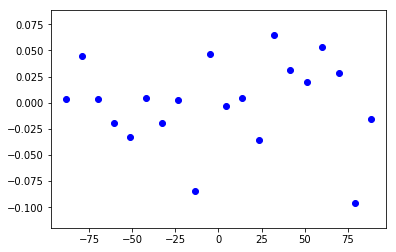

In [13]:
## Exercise 4
def reducirDimensionalidadDataset(dataset, baseVectors):
    """
    Reduce dataset dimensionality
    dataset: 
    baseVectors: 
    """
    
    def plotReduceMatrixAndScatteredPoints(reduceMatrix):
      """
      Scattered Matrix Points
      A: Matrix with the set of samples.
      """

      # Scattered matrix points
      plt.scatter(reduceMatrix[0, :].numpy(), reduceMatrix[1, :].numpy(), c='b', marker='o')

      plt.show()
      
    # Substract the mean to the data for data normalization
    meanSamplePerVariable = torch.mean(dataset, 1)
    meanSamplePerVariableTranspose = meanSamplePerVariable.reshape(-1, meanSamplePerVariable.shape[0]).transpose(0, 1)
    newDataset = dataset - meanSamplePerVariableTranspose
    
    # 2D data samples
    numDataSamples = newDataset.shape[0]
    dataset2D = torch.zeros(numDataSamples, 2)
    base1 = baseVectors[:, 0].squeeze()
    base2 = baseVectors[:, 1].squeeze()
    
    # Reduce matrix
    reduceMatrix = torch.zeros(2, 20)
    
    # Calculate u*v1
    firstRow = (base1*newDataset.transpose(0, 1)).sum(1, keepdim = True).transpose(0, 1)
    
    # Calculate u*v2
    secondRow = (base2*newDataset.transpose(0, 1)).sum(1, keepdim = True).transpose(0, 1)
    
    # Set new matrix
    reduceMatrix[0, :] = firstRow
    reduceMatrix[1, :] = secondRow
    
    print("Reduce Matrix: \n", reduceMatrix)
    print("Reduce Matrix Shape: \n", reduceMatrix.shape)
    
    # Plot reduce matrix
    plotReduceMatrixAndScatteredPoints(reduceMatrix)
    
    return reduceMatrix
    


# Test reducing the dimensionality of a dataset.
reduceMatrix = reducirDimensionalidadDataset(matrizX, baseVectors)




# 5) Calcular el error utilizando dos autovectores (30 puntos)

In [14]:
## Exercise 5
def calcularErrorAutovectores(dataset, V):
    def calculateRMSE(u, v):
      """
      Calculates the Root mean squared error (RMSE)
      return RMSE
      """
      criterion = torch.nn.MSELoss()
      return torch.sqrt(criterion(u, v))
  
    # Substract the mean to the data for data normalization
    meanSamplePerVariable = torch.mean(dataset, 1)
    meanSamplePerVariableTranspose = meanSamplePerVariable.reshape(-1, meanSamplePerVariable.shape[0]).transpose(0, 1)
    U = dataset - meanSamplePerVariableTranspose
    
    # Calculate P = V*Vpinverse*U
    baseVectorsPinv = torch.tensor(np.linalg.pinv(V))
    projectionDataset = V.mm(baseVectorsPinv).mm(U)
    
    # Calculate the error of the projected samples
    error = calculateRMSE(projectionDataset, U)
    return error


# Test Exercise 5
error = calcularErrorAutovectores(matrizX, baseVectors)
print("Error: \n", error)

bestAutovector = baseVectors[:, 0]
bestAutovector = bestAutovector.reshape(-1, bestAutovector.shape[0]).transpose(0, 1)
print("Best autovector: \n", bestAutovector)
error = calcularErrorAutovectores(matrizX, bestAutovector)
print("Error of best autovector: \n", error)





Error: 
 tensor(6.5446e-05)
Best autovector: 
 tensor([[0.0645],
        [0.6992],
        [0.7120]])
Error of best autovector: 
 tensor(0.0235)
